# Libraries

In [19]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# importing libraries for VADER  
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud, STOPWORDS
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import multiprocessing
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import classification_report

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

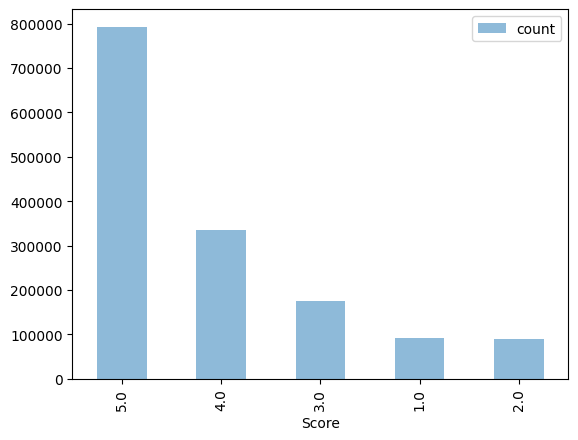


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [20]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [21]:
# Calculate the class imbalance
score_distribution = trainingSet['Score'].value_counts().sort_index()
class_imbalance = score_distribution.min() / score_distribution.max()
print(f"Class Frequency: {score_distribution}")
print()
print(f"Class Imbalance Ratio: {class_imbalance:.2f}")

Class Frequency: Score
1.0     91190
2.0     89678
3.0    176082
4.0    335228
5.0    793163
Name: count, dtype: int64

Class Imbalance Ratio: 0.11


In [22]:
# Separate each class
class_1 = trainingSet[trainingSet['Score'] == 1]
class_2 = trainingSet[trainingSet['Score'] == 2]
class_3 = trainingSet[trainingSet['Score'] == 3]
class_4 = trainingSet[trainingSet['Score'] == 4]
class_5 = trainingSet[trainingSet['Score'] == 5]

# Downsample class 5
class_5_downsampled = resample(class_5, replace=False, n_samples=len(class_4), random_state=42)

# Optional: Upsample classes with fewer samples
class_1_upsampled = resample(class_1, replace=True, n_samples=len(class_4), random_state=42)
class_2_upsampled = resample(class_2, replace=True, n_samples=len(class_4), random_state=42)
class_3_upsampled = resample(class_3, replace=True, n_samples=len(class_4), random_state=42)

# Combine all classes into a new balanced dataset
trainingSet_balanced = pd.concat([class_1_upsampled, class_2_upsampled, class_3_upsampled, class_4, class_5_downsampled])

In [36]:
# Calculate the class imbalance
score_distribution = trainingSet_balanced['Score'].value_counts().sort_index()
class_imbalance = score_distribution.min() / score_distribution.max()
print(f"Class Frequency: {score_distribution}")
print()
print(f"Class Imbalance Ratio: {class_imbalance:.2f}")

# perfecctly balanced dataset ? explore potential issues

Class Frequency: Score
1.0    335228
2.0    335228
3.0    335228
4.0    335228
5.0    335228
Name: count, dtype: int64

Class Imbalance Ratio: 1.00


# Adding Features

In [24]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER compound score for a given text
def get_vader_sentiment(text, idx):
    if not isinstance(text, str):
        text = ''
    if idx % 100000 == 0:  # Print progress every 100,000 rows
        print(f"Processing row {idx}")
    return analyzer.polarity_scores(text)['compound']

def parallel_vader_sentiment(df, text_column):
    num_cores = multiprocessing.cpu_count()

    sentiment_scores = Parallel(n_jobs=num_cores)(
        delayed(get_vader_sentiment)(text, i) for i, text in enumerate(df[text_column])
    )
    return sentiment_scores

def add_features_to(df):
    # This is where you can do all your feature extraction

    # Calculate 'Helpfulness' feature
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Drop HelpfulnessNumerator and HelpfulnessDenominator
    df = df.drop(columns=['HelpfulnessNumerator', 'HelpfulnessDenominator'])

    # Convert Time to datetime
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    # ridge does not work with datetime need to convert to int
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['Day'] = df['Time'].dt.day
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df.drop(columns=['Time'], inplace=True)

    # impute missing values with empty strings
    df['Text'] = df['Text'].fillna('').astype(str)
    df['Summary'] = df['Summary'].fillna('').astype(str)
    # Convert any non-string entries in 'Text' column to strings

    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if row['Text'] else 0, axis = 1)

    # Extract the sentiment from the summary and text    
    df['Text_Sentiment'] = parallel_vader_sentiment(trainingSet, 'Text')
    # trainingSet['Summary_Sentiment'] = parallel_vader_sentiment(trainingSet, 'Summary')
    # created a lot of noise

    print(df[['Text_Sentiment']].head())
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame in chunks
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

Processing row 0
Processing row 100000
Processing row 200000
Processing row 300000
Processing row 400000
Processing row 500000
Processing row 600000
Processing row 700000
Processing row 800000
Processing row 900000
Processing row 1000000
Processing row 1100000
Processing row 1200000
Processing row 1300000
Processing row 1400000
Processing row 1500000
Processing row 1600000
   Text_Sentiment
0         -0.6205
1          0.4939
2          0.9733
3          0.9750
4          0.9981


# Sample + Split into training and testing set

In [25]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=42
)

In [26]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_submission:", X_submission.columns)

Columns in X_train: Index(['Id', 'ProductId', 'UserId', 'Summary', 'Text', 'Helpfulness', 'Year',
       'Month', 'Day', 'DayOfWeek', 'ReviewLength', 'Text_Sentiment'],
      dtype='object')
Columns in X_submission: Index(['Id', 'ProductId', 'UserId', 'Summary', 'Text', 'Helpfulness', 'Year',
       'Month', 'Day', 'DayOfWeek', 'ReviewLength', 'Text_Sentiment', 'Score'],
      dtype='object')


# Feature Selection

In [27]:
features = ['Id', 'Text_Sentiment', 'Helpfulness', 'DayOfWeek', 'ReviewLength']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [28]:
# Learn the model
# Initialize the Gradient Boosting model
# model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# # Fit the model
# model.fit(X_train_select, Y_train)

# # Predict the score using the model
# Y_test_predictions = model.predict(X_test_select)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'max_depth': [3, 5]
}

# Select a small subset of the training data was taking too long
X_train_small = X_train_select.sample(frac=0.1, random_state=42)  # 10% of the data
Y_train_small = Y_train.loc[X_train_small.index]

# Initialize GridSearchCV with GradientBoostingClassifier
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=3)

# Fit grid search on training data
grid_search.fit(X_train_small, Y_train_small)

# Retrieve the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Y_test_predictions = best_model.predict(X_test_select)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


KeyboardInterrupt: 

In [30]:
# Define parameter distributions
param_distributions = {
    'n_estimators': [50, 100, 150, 200],        # Try different values for the number of trees
    'learning_rate': np.linspace(0.01, 0.2, 5), # Range for learning rates (5 values between 0.01 and 0.2)
    'max_depth': [3, 4, 5, 6, 7],               # Different max depth values
    'subsample': [0.6, 0.8, 1.0],               # Include subsample parameter to control overfitting
    'min_samples_split': [2, 5, 10]             # Minimum number of samples required to split a node
}

# Initialize RandomizedSearchCV with GradientBoostingClassifier
random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,                        # Number of parameter settings to sample
    scoring='accuracy',                # Scoring metric for evaluation
    cv=3,                              # 3-fold cross-validation
    n_jobs=-1,                         # Use all available cores
    verbose=3,                         # Print progress
    random_state=42                    # Set random state for reproducibility
)

# Select a smaller subset to reduce runtime
X_train_small = X_train_select.sample(frac=0.1, random_state=42)  # 10% of the data
Y_train_small = Y_train.loc[X_train_small.index]

# Fit RandomizedSearchCV
random_search.fit(X_train_small, Y_train_small)

# Retrieve the best model and parameters
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Use the best model to make predictions
Y_test_predictions = best_model.predict(X_test_select)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 2/3] END learning_rate=0.0575, max_depth=4, min_samples_split=5, n_estimators=100, subsample=0.6;, score=0.554 total time=  29.9s
[CV 1/3] END learning_rate=0.0575, max_depth=4, min_samples_split=5, n_estimators=100, subsample=0.6;, score=0.552 total time=  30.2s
[CV 1/3] END learning_rate=0.15250000000000002, max_depth=4, min_samples_split=5, n_estimators=50, subsample=0.6;, score=0.552 total time=  15.2s
[CV 3/3] END learning_rate=0.0575, max_depth=4, min_samples_split=5, n_estimators=100, subsample=0.6;, score=0.556 total time=  30.8s
[CV 2/3] END learning_rate=0.15250000000000002, max_depth=4, min_samples_split=5, n_estimators=50, subsample=0.6;, score=0.555 total time=  15.5s
[CV 3/3] END learning_rate=0.15250000000000002, max_depth=4, min_samples_split=5, n_estimators=50, subsample=0.6;, score=0.555 total time=  16.1s
[CV 1/3] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.8

best parameters found from above are

        subsample: 1.0

        n_estimators: 200

        min_samples_split: 2

        max_depth: 3

        learning_rate: 0.2

based on cross-validated accuracy scores for each combination tested.

In [32]:
best_params = random_search.best_params_
final_model = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=1.0,
    min_samples_split=2,
    random_state=42
)

# Fit the model on the full training data
final_model.fit(X_train_select, Y_train)

# Predict on the test data
Y_test_predictions = final_model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.5593586401533921


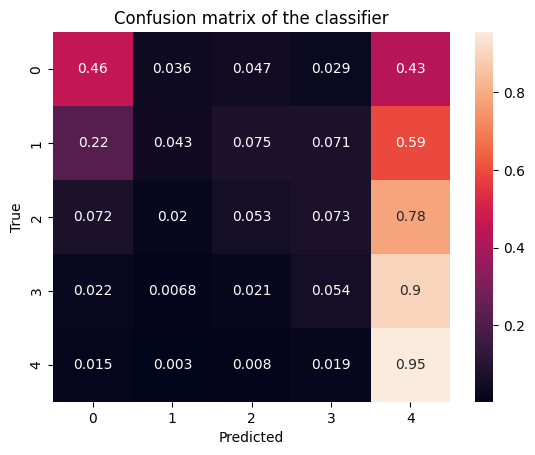

Classification Report:
               precision    recall  f1-score   support

         1.0       0.45      0.46      0.45     22649
         2.0       0.25      0.04      0.07     22182
         3.0       0.28      0.05      0.09     43979
         4.0       0.33      0.05      0.09     83939
         5.0       0.59      0.95      0.73    198587

    accuracy                           0.56    371336
   macro avg       0.38      0.31      0.29    371336
weighted avg       0.46      0.56      0.45    371336



In [33]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
# previous accuracy was 0.5566764332033522

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

report = classification_report(Y_test, Y_test_predictions)
print("Classification Report:\n", report)

# Create submission file

In [34]:
# Create the submission file
X_submission['Score'] = final_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)